I use a voting system, where each model only votes if they are sure about their value. If they are not sure, they do not vote.

For now, all models vote the same number of times.

The predictions were obtained without taking `te` and `val` into account.

In [1]:
%load_ext autotime

In [2]:
%load_ext autoreload
%autoreload 2

time: 33.3 ms


In [3]:
import numpy as np
import scipy.sparse as sp
from datafile_methods.data_processing import load_data
from datafile_methods.data_io import save_csv
DATA_PATH = '../data/'
PREDICTION_PATH = '../data/predictions/'

time: 181 ms


### Load data

In [4]:
from datafile_methods.data_io import load_datasets

# Load datasets
folds, ratings, sample_submission = load_datasets()

time: 15 s


Load predictions for each prediction model

In [5]:
models = ['baseline',
          'knn_baseline_i',
          'knn_baseline_u',
          'mf_svd_sci',
          'nmf',
          'slope_one',
          'sur_svd',
          'mf_als_recommend',
          'mf_als']

time: 9.63 ms


In [6]:
# Load predictions for each fold and model
predictions = [[load_data('{p}model_{m}_te_{i}.csv'.format(p=PREDICTION_PATH, m=model, i=i)) for i in range(5)] for model in models]
predictions_dict = dict(zip(models, predictions))

time: 45.7 s


### Divide the set into B disjoint subsets

#### Justification

Support : The support of a data point (u, i) is the
number of votes by user u. The blender can now base
the weighting of predictors dependent on how many
rating the user has given. RBMs are prone to receive
high weight when the user has only a few votes in the
data. SVDs are highly weighted when much information
from a user is available.

http://elf-project.sourceforge.net/CombiningPredictionsForAccurateRecommenderSystems.pdf

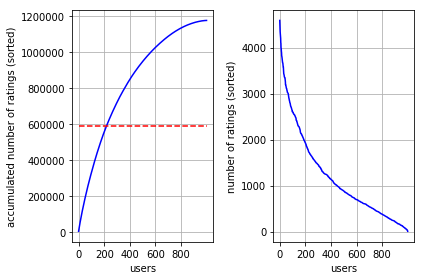

time: 259 ms


In [8]:
from plots import plot_raw_data
num_items_per_user, num_users_per_item = plot_raw_data(ratings)

#### Actual division of set

In [9]:
from datafile_methods.data_processing import disjoint_subsets_on_support, obtain_indices_high_support

time: 10.1 ms


In [10]:
ind = obtain_indices_high_support(ratings)

# Split predictions according to support level
predictions_high = {k: [disjoint_subsets_on_support(v[i], ind)[0] for i in range(5)]
    for k,v in predictions_dict.items()}
predictions_low = {k: [disjoint_subsets_on_support(v[i], ind)[1] for i in range(5)]
    for k,v in predictions_dict.items()}

# Get the prediction values from the sparse matrices
predictions_vals = {k: [sp.find(f)[2] for f in v] for k,v in predictions_dict.items()}
predictions_high_vals = {k: [sp.find(f)[2] for f in v] for k,v in predictions_high.items()}
predictions_low_vals = {k: [sp.find(f)[2] for f in v] for k,v in predictions_low.items()}

time: 10.3 s


In [11]:
# Split observed ratings according to support level
observations_high = [disjoint_subsets_on_support(f, ind)[0] for f in folds]
observations_low = [disjoint_subsets_on_support(f, ind)[1] for f in folds]

# Get the prediction values from the sparse matrices
observations_vals = [sp.find(f)[2] for f in folds]
observations_high_vals = [sp.find(f)[2] for f in observations_high]
observations_low_vals = [sp.find(f)[2] for f in observations_low]

time: 1.15 s


### Determine a separate blending for each subset

In [12]:
import pandas as pd

time: 207 ms


#### Create dataframes

In [13]:
predictions_high_df = [pd.DataFrame({model: obs[i] for model, obs in predictions_high_vals.items()}) for i in range(5)]
predictions_low_df = [pd.DataFrame({model: obs[i] for model, obs in predictions_low_vals.items()}) for i in range(5)]

time: 46 ms


In [14]:
# Create dataframes with observed values
observations_high_df = [pd.DataFrame(f) for f in observations_high_vals]
observations_low_df = [pd.DataFrame(f) for f in observations_low_vals]

time: 15.7 ms


In [15]:
def compute_mean_predictions(predictions_df, chosen_models):
    return predictions_df[chosen_models].mean(axis=1)

def compute_mean_fold_predictions(predictions_df_list, chosen_models):
    return [compute_mean_predictions(f, chosen_models) for f in predictions_df_list]

time: 10.6 ms


#### High support - generate data for possible plots

#### Low support - generate data for possible plots

#### Do weighted mean of predictions for previously estimated weights

In [16]:
# Load predictions of submission entries with each model
predictions_sub = [load_data('{p}model_{m}_sub.csv'.format(p=PREDICTION_PATH, m=model)) for model in models]
predictions_sub_dict = dict(zip(models, predictions_sub))

time: 46.5 s


In [17]:
# Separate submission data into high and low support ratings
predictions_sub_high = {k: disjoint_subsets_on_support(v, ind)[0] for k,v in predictions_sub_dict.items()}
predictions_sub_low = {k: disjoint_subsets_on_support(v, ind)[1] for k,v in predictions_sub_dict.items()}

time: 3.3 s


In [18]:
# Define weights as estimated
high_w = {'baseline': 0,
          'knn_baseline_u': 0,
          'sur_svd': 1.0/2,
          'mf_als_recommend': 1.0/8,
          'mf_als': 1.0/8,
          'knn_baseline_i': 1.0/16,
          'mf_svd_sci': 1.0/16,
          'nmf': 1.0/16,
          'slope_one': 1.0/16}

low_w = {'mf_als': 1.0/3,
         'baseline': 0,
         'knn_baseline_u': 0,
         'nmf': 0,
         'slope_one': 0,
         'knn_baseline_i': 0,
         'sur_svd': 1.0/3,
         'mf_als_recommend': 1.0/6,
         'mf_svd_sci': 1.0/6}

time: 19.5 ms


In [19]:
# Obtain weighted mean predictions for submission file
sp_mean_sub_high = np.sum([(high_w[m] * predictions_sub_high[m]) for m in models])
sp_mean_sub_low = np.sum([(low_w[m] * predictions_sub_low[m]) for m in models])
# Join predictions for high and low support
sp_mean_sub = sp_mean_sub_high + sp_mean_sub_low

time: 6.05 s


In [217]:
# Export file
save_csv(sp_mean_sub, prediction_path=PREDICTION_PATH, filename='combination_manual')

time: 12.9 s


# Other stuff

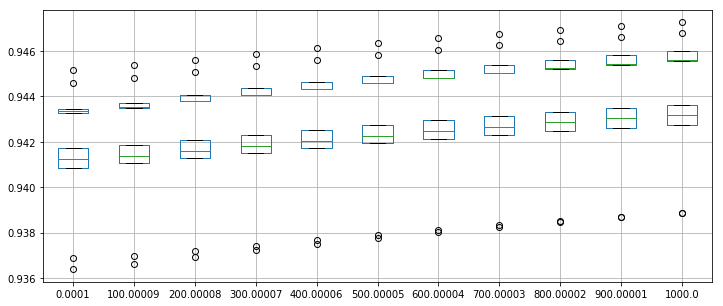

time: 433 ms


In [124]:
plt.figure(figsize=(12,5))
pd.DataFrame(train_errors).boxplot()
pd.DataFrame(test_errors).boxplot()
plt.show()

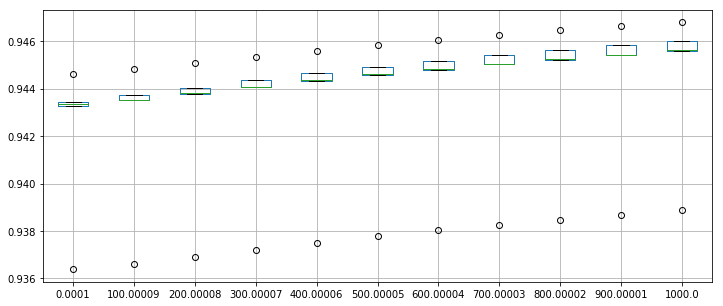

time: 303 ms


In [125]:
plt.figure(figsize=(12,5))
pd.DataFrame(train_errors).boxplot()
plt.show()

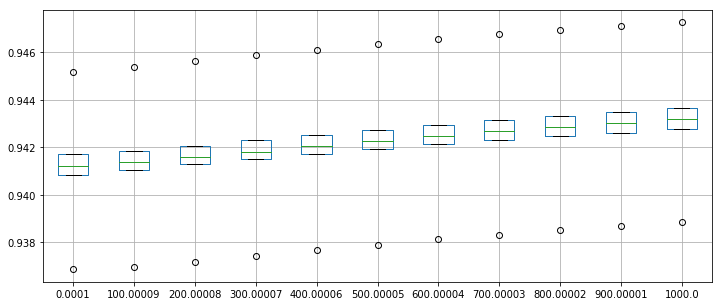

time: 503 ms


In [126]:
plt.figure(figsize=(12,5))
pd.DataFrame(test_errors).boxplot()
plt.show()

#### Apply Ridge Regression (low support)

In [222]:
from sklearn.linear_model import Ridge

y = df_obs_te_low.copy()
X = df_pred_te_low.copy()
test = df_pred_te_low.copy()

clf = Ridge(alpha=10, fit_intercept=False)
clf.fit(X, y)

pred = pd.DataFrame(clf.predict(X))

clf.coef_

array([[ 0.45234053, -0.63754525,  3.01324681, -2.32361609, -0.06606462,
        -0.83506026, -0.84061446, -1.12972476,  3.36504768]])

time: 119 ms


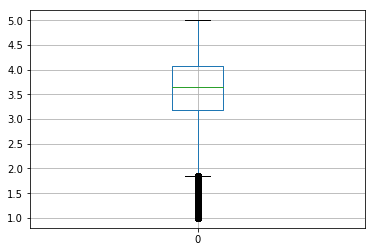

time: 167 ms


In [224]:
pred = np.clip(pred, 1.0, 5.0)

pred.boxplot()
plt.show()

Save weights in DataFrame

In [28]:
model_weights = pd.Series(data=dict(zip(models, clf.coef_.flatten())), name='weights')

time: 5.65 ms


In [31]:
#TODO: Get test RMSE, for all alpha-fold combinations

time: 1.87 ms


In [32]:
# Choose best alpha

time: 1.67 ms


In [38]:
# Do a mean of the 5 weights (one per fold) for the best alpha

time: 1.84 ms


### Get a *mean* prediction

In [30]:
# Obtain weighted mean predictions
sp_mean_tr = np.sum([(model_weights[m] * sp_dict_tr[m]) for m in models])
sp_mean_sub = np.sum([(model_weights[m] * sp_dict_sub[m]) for m in models])

time: 151 ms


# From here on I don't think it's useful
But I can comment on the report that the voting system didn't work :)

### Do some processing

In [12]:
tol=0.01
min_v=15

time: 1.09 ms


#### Get valid votes

In [14]:
def decide_vote_gen(tol):
    def decide_vote(pred):
        """Defines if a model gets to vote or not"""
        vote = round(pred)
        if (tol > abs(vote - pred)):
            return vote
        else:
            return np.nan
    return decide_vote

time: 5.22 ms


In [15]:
# See if the predictions are valid votes or not
df_votes_tr = df_pred_tr.applymap(decide_vote_gen(tol))
df_votes_sub = df_pred_sub.applymap(decide_vote_gen(tol))

time: 13.1 s


In [16]:
# Have each model vote as many times as specified
df_final_votes_tr = df_votes_tr[['nmf']]
df_final_votes_sub = df_votes_sub[['nmf']]
for m in df_votes_tr.columns:
    for i in range(model_weights['n_votes'][m]):
        df_final_votes_tr['{}_{}'.format(m,i)] = df_votes_tr[m]
        df_final_votes_sub['{}_{}'.format(m,i)] = df_votes_sub[m]

df_final_votes_tr = df_final_votes_tr.drop('nmf', axis=1)
df_final_votes_sub = df_final_votes_sub.drop('nmf', axis=1)

/home/lucia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/lucia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


time: 1.12 s


In [17]:
df_pred_tr['median_vote'] = df_final_votes_tr.median(axis=1)
df_pred_sub['median_vote'] = df_final_votes_sub.median(axis=1)

n_votes_tr = df_final_votes_tr.notnull().sum(axis=1)
n_votes_sub = df_final_votes_sub.notnull().sum(axis=1)

df_pred_tr['median_vote'][n_votes_tr < min_v] = np.nan
df_pred_sub['median_vote'][n_votes_sub < min_v] = np.nan

## Get weighted mean
# Add column with mean values
df_pred_tr['mean'] = pd.Series(sp.find(sp_mean_tr)[2])
df_pred_sub['mean'] = pd.Series(sp.find(sp_mean_sub)[2])

# Combine decisions and means
df_pred_tr['final'] = df_pred_tr['median_vote'].combine_first(df_pred_tr['mean'])
df_pred_sub['final'] = df_pred_sub['median_vote'].combine_first(df_pred_sub['mean'])

## Look at the results
e_round['{}_{}'.format(tol, min_v)] = np.sqrt(np.mean((df_obs_tr[0] - df_pred_tr['final'])**2))
e_mean['{}_{}'.format(tol, min_v)] = np.sqrt(np.mean((df_obs_tr[0] - df_pred_tr['mean'])**2))

time: 1.43 s


In [18]:
e_round

{'0.01_15': 0.9563223823375252}

time: 7.81 ms


In [19]:
e_mean

{'0.01_15': 0.95631678161799194}

time: 5.56 ms


#### Save...

In [29]:
(r, c, v) = sp.find(sp_mean_sub)

time: 217 ms


In [35]:
sp_final = sp.csr_matrix((df_pred_sub['final'], (r, c)), shape=sp_mean_sub.shape)

time: 240 ms


In [36]:
save_csv(sp_final, prediction_path=PREDICTION_PATH, filename='combination_final')

time: 14 s
